# Following the Video Code

For notes and to ensure understanding.

In [1]:
from functools import partial
import torch

import seaborn as sns
from numpy.random import normal

from ipywidgets import interact

import warnings

In [2]:
# set plot style for dark mode (not necessary to understand the notebook)
sns.set_theme(rc={
                  'font.size': 10,
                  'xtick.labelsize': 8,
                  'ytick.labelsize': 8,
                  'axes.labelsize': 8,
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'axes.facecolor': '#1E1E1E',  # Very dark gray
                  'figure.facecolor': '#1E1E1E',  # Very dark gray
                  'axes.grid': False,
                  'xtick.color': 'w',  # White x-axis tick labels
                  'ytick.color': 'w',  # White y-axis tick labels
                  'text.color': 'w',  # White text
                  'axes.labelcolor': 'w',  # White axis labels
                  'figure.titlesize': 'large',  # Set the size of the figure title
                  'figure.titleweight': 'bold',  # Set the weight of the figure title
              })

# store a colour palette
col_pal = sns.color_palette("muted")
sns.set_palette(col_pal)

In [3]:
# disable future warning, issue in seaborn library - not the notebook code

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def quad(a, b, c, x):
    return a*x ** 2 + b*x + c

quad(3, 2, 1, 2)

17

In [5]:
f = partial(quad, 3, 2, 1)
f(2)

17

In [6]:
x = torch.linspace(-2, 2, 40)
x

tensor([-2.0000, -1.8974, -1.7949, -1.6923, -1.5897, -1.4872, -1.3846, -1.2821,
        -1.1795, -1.0769, -0.9744, -0.8718, -0.7692, -0.6667, -0.5641, -0.4615,
        -0.3590, -0.2564, -0.1538, -0.0513,  0.0513,  0.1538,  0.2564,  0.3590,
         0.4615,  0.5641,  0.6667,  0.7692,  0.8718,  0.9744,  1.0769,  1.1795,
         1.2821,  1.3846,  1.4872,  1.5897,  1.6923,  1.7949,  1.8974,  2.0000])

In [7]:
y = f(x)
y

tensor([ 9.0000,  8.0059,  7.0750,  6.2071,  5.4024,  4.6607,  3.9822,  3.3669,
         2.8146,  2.3254,  1.8994,  1.5365,  1.2367,  1.0000,  0.8264,  0.7160,
         0.6686,  0.6844,  0.7633,  0.9053,  1.1105,  1.3787,  1.7101,  2.1045,
         2.5621,  3.0828,  3.6667,  4.3136,  5.0237,  5.7968,  6.6331,  7.5325,
         8.4951,  9.5207, 10.6095, 11.7613, 12.9763, 14.2544, 15.5957, 17.0000])

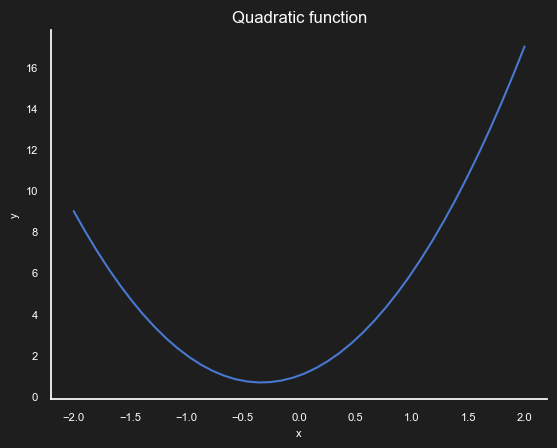

In [8]:
sns.lineplot(x=x, y=y).set(title='Quadratic function', 
                           xlabel='x', 
                           ylabel='y');

In [9]:
x.size()

torch.Size([40])

In [10]:
def add_noise(x, mult, add):
    mult_noise = 1 + normal(scale=mult, size=x.size())
    add_noise = normal(scale=add, size=x.size())
    return x * mult_noise + add_noise

data_y = add_noise(y, 0.3, 1.2)

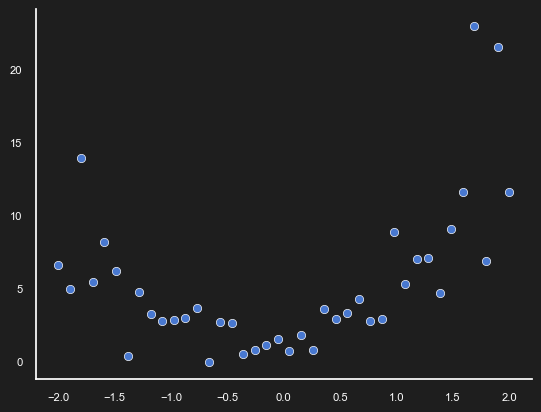

In [11]:
sns.scatterplot(x=x, y=data_y);

## Fit by Hand

In [12]:
def mk_quad(a,b,c): return partial(quad, a, b, c)

In [13]:
@interact(a=1.5, b=1.5, c=1.5)
def explore_quad_coefs(a, b, c):
    sns.scatterplot(x=x, y=data_y)
    
    f = mk_quad(a, b, c)
    y = f(x)
    sns.lineplot(x=x, y=y).set(ylim=[-3, 20])

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [14]:
def mse(real, pred):
    return ((real - pred)**2).mean()

In [15]:
@interact(a=1.5, b=1.5, c=1.5)
def explore_quad_coefs(a, b, c):
    sns.scatterplot(x=x, y=data_y)
    
    f = partial(quad, a, b, c)
    y = f(x)
    loss = mse(data_y, y)
    sns.lineplot(x=x, y=y).set(ylim=[-3, 20], title=f'MSE: {loss:.2f}')

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Automate Fitting with Loss

In [16]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(data_y, f(x))

In [17]:
quad_mse([1.5, 1.5, 1.5])

tensor(14.9895, dtype=torch.float64)

In [18]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

Requires grad means that every time the tensor is used in a function the gradient is calculated.

In [19]:
loss = quad_mse(abc)
loss

tensor(14.9895, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [20]:
loss.backward()

In [21]:
abc.grad

tensor([-9.0787, -0.4768, -3.5277])

We don't want the gradient to be calculated when we use ```abc -= abc.grad*1e-2``` because this is us updating the gradient, not the loss function itself. 

In [22]:
with torch.no_grad():
    abc -= abc.grad*1e-2
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=14.08


In [23]:
loss

tensor(14.0779, dtype=torch.float64)

In [24]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad*1e-2
    print(f'step = {i}, loss = {loss:.2f}')
    

step = 0, loss = 14.08
step = 1, loss = 12.55
step = 2, loss = 10.90
step = 3, loss = 9.67
step = 4, loss = 9.24


In [25]:
abc

tensor([2.9375, 1.5911, 2.0352], requires_grad=True)

## Which Function is Best to Make Predictions for Our Loss function?

When many are stacked together, ReLU makes for an excellent general use function. This would be what replaces the quadratic in the previous examples above.

In [42]:
def rectified_linear(m, b, x):
    y = m*x + b
    return torch.clip(y, 0.)

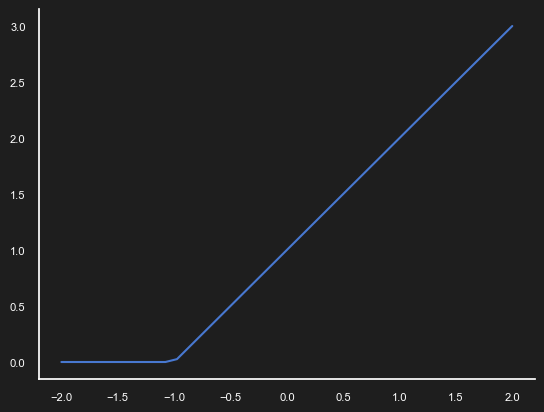

In [27]:
sns.lineplot(x=x, y=rectified_linear(1,1, x));

In [35]:
@interact(m=1.0, b=1.0)
def plot_relu(m, b):
    sns.lineplot(x=x, y=rectified_linear(m, b, x)).set(xlim=[-2, 2], 
                                                       ylim=[-0.5, 3])

interactive(children=(FloatSlider(value=1.0, description='m', max=3.0, min=-1.0), FloatSlider(value=1.0, descr…

In [40]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [41]:
@interact(m1=1.0, b1=1.0, m2=1.0, b2=1.0)
def plot_double_relu(m1, b1, m2, b2):
    sns.lineplot(x=x, y=double_relu(m1, b1, m2, b2, x)).set(xlim=[-2, 2], 
                                                           ylim=[-0.5, 3])

interactive(children=(FloatSlider(value=1.0, description='m1', max=3.0, min=-1.0), FloatSlider(value=1.0, desc…